## **Time-LLM Multivariate**

Install required modules

In [ ]:
pip install neuralforecast==1.7.4 transformers==4.42.4 GPUtil==1.4.0 psutil numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4 torch==2.4.0 platform

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

Import required modules

In [ ]:
import torch
import psutil
import platform
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeLLM
from neuralforecast.utils import AirPassengersDF
from neuralforecast.utils import AirPassengersPanel, augment_calendar_df
from transformers import GPT2Config, GPT2Model, GPT2Tokenizer


Display **GPU** and **CPU** information

In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__CUDA Device Name: Tesla T4
__CUDA Device Total Memory [GB]: 15.835660288


In [ ]:
# Get memory information
mem = psutil.virtual_memory()

# Print available memory
print("Available Memory:")
print("  Total:", mem.total / (1024 ** 2), "MB")

# Get CPU information
cpu_count = psutil.cpu_count()
cpu_count_logical = psutil.cpu_count(logical=True)

# Print CPU details
print("\nCPU Details:")
print("  Physical Cores:", cpu_count)
print("  Logical Cores:", cpu_count_logical)

# Get platform information
platform_info = platform.platform()

# Print platform information
print("\nPlatform:", platform_info)

Available Memory:
  Total: 12978.96484375 MB

CPU Details:
  Physical Cores: 2
  Logical Cores: 2

Platform: Linux-6.1.85+-x86_64-with-glibc2.35


Create calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Load AirPassenger data set and split data into train and test

In [ ]:
AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

# To load local csv  > modify to the right path where the file is present
#Y_df = pd.read_csv('AirPassengersPanel.csv')
#Y_df = Y_df.reset_index(drop=True)
#Y_df.head()

Other features apart from "y" is added as exogenous variables

In [ ]:
Y_train_df

,unique_id,ds,y,trend,y_[lag12],month
0,Airline1,1949-01-31,112.0,0,112.0,-0.500000
1,Airline1,1949-02-28,118.0,1,118.0,-0.409091
2,Airline1,1949-03-31,132.0,2,132.0,-0.318182
3,Airline1,1949-04-30,129.0,3,129.0,-0.227273
4,Airline1,1949-05-31,121.0,4,121.0,-0.136364
...,...,...,...,...,...,...
271,Airline2,1959-08-31,859.0,271,805.0,0.136364
272,Airline2,1959-09-30,763.0,272,704.0,0.227273
273,Airline2,1959-10-31,707.0,273,659.0,0.318182
274,Airline2,1959-11-30,662.0,274,610.0,0.409091


Setting up GPT2

In [ ]:
gpt2_config = GPT2Config.from_pretrained('openai-community/gpt2')
gpt2 = GPT2Model.from_pretrained('openai-community/gpt2', config=gpt2_config)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('openai-community/gpt2')
prompt_prefix = "The dataset contains data on monthly air passengers. There is a yearly seasonality"


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Lets initialize and training model (**TimeLLM**) and define its hyperparameters.

In [ ]:
horizon = 12
timellm = TimeLLM(h=horizon,
                 input_size=36,
                 llm=gpt2,
                 llm_config=gpt2_config,
                 llm_tokenizer=gpt2_tokenizer,
                 prompt_prefix=prompt_prefix,
                 batch_size=24,
                 windows_batch_size=24)

nf = NeuralForecast(
    models=[timellm],
    freq='M'
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
# 26 minutes to train
nf.fit(df=Y_train_df, val_size=12)

/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 124 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=5` reached.


Lets try predicting by passing future exogenous which are part of test data prepared earlier

In [ ]:
# 25 min to predict
forecasts = nf.predict(futr_df=Y_test_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


Measure the models accuracy

In [ ]:
calculate_error_metrics(Y_test_df[['y']],forecasts['TimeLLM'])

MSE : 9568.9033203125
RMSE : 97.82077026367188
MAPE : 0.13793222606182098
r2 : 0.6587345516012689
adjusted_r2 : 0.643222485764963


Predictions for Airline1

In [ ]:

forecasts['TimeLLM'][:12]

,TimeLLM
unique_id,
Airline1,340.337128
Airline1,438.639801
Airline1,516.180298
Airline1,354.548615
Airline1,449.864777
Airline1,415.037964
Airline1,457.495026
Airline1,450.726074
Airline1,485.232635


Predictions for Airline2

In [ ]:

forecasts['TimeLLM'][12:]

,TimeLLM
unique_id,
Airline2,639.903687
Airline2,739.086670
Airline2,817.289307
Airline2,654.157349
Airline2,750.472900
Airline2,715.044678
Airline2,758.234802
Airline2,751.383972
Airline2,786.069458


Visualize the predictions

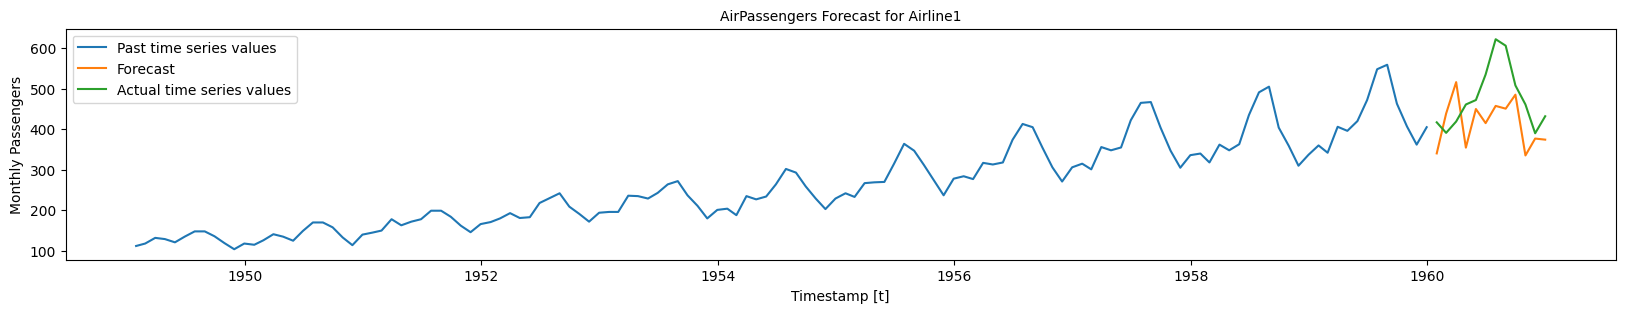

In [ ]:
train_df_1 = Y_train_df[Y_train_df.unique_id == 'Airline1']
airline_df_1 = Y_test_df[Y_test_df.unique_id == 'Airline1']
train_df_1.set_index('ds',inplace =True)
forecasts.set_index('ds',inplace =True)
airline_df_1.set_index('ds',inplace =True)
plt.figure(figsize=(20, 3))
y_past = train_df_1["y"]
y_pred = forecasts['TimeLLM'][:12]
y_test = airline_df_1["y"]
plt.plot(y_past, label="Past time series values")
plt.plot(y_pred, label="Forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast for Airline1', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)

plt.legend();

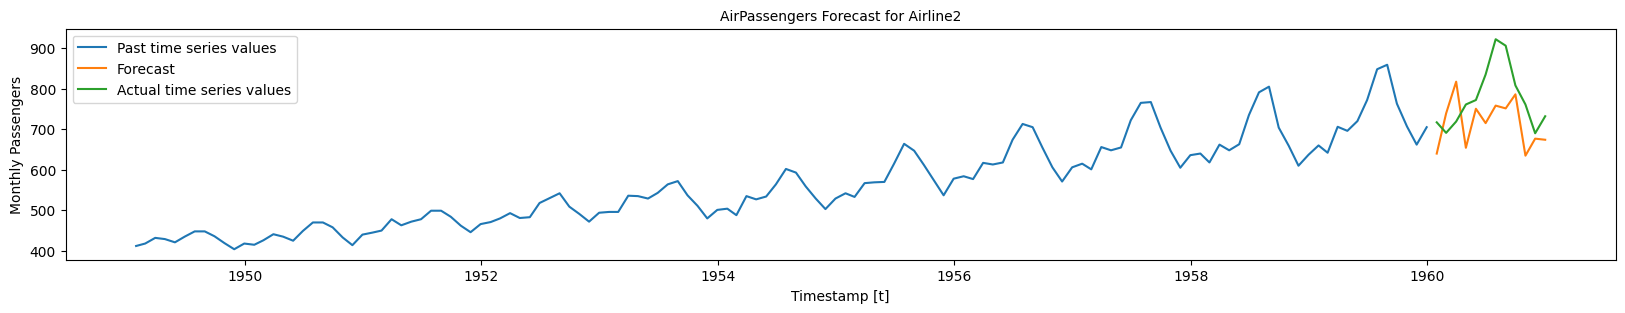

In [ ]:
train_df_2 = Y_train_df[Y_train_df.unique_id == 'Airline2']
airline_df_2 = Y_test_df[Y_test_df.unique_id == 'Airline2']
train_df_2.set_index('ds',inplace =True)
#forecasts.set_index('ds',inplace =True)
airline_df_2.set_index('ds',inplace =True)
plt.figure(figsize=(20, 3))
y_past = train_df_2["y"]
y_pred = forecasts['TimeLLM'][12:]
y_test = airline_df_2["y"]
plt.plot(y_past, label="Past time series values")
plt.plot(y_pred, label="Forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast for Airline2', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)
plt.legend();